In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastcore.all import *
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.vision.core import *
from fastai.basics import *

In [ ]:
#hide
import re
import random
import math
import functools
import sys
import os


#from fastai.data.core import DataLoaders

#from fastai.vision.data import *
from fastai.vision.augment import *
#from fastai.vision.gan import *
#from fastai.vision.models.all import *
#from fastai.basics import *

In [ ]:
#export 
class ImageNTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        all_tensors = all([isinstance(t, Tensor) for t in self])
        same_shape = all([self[0].shape==t.shape for t in self[1:]])
        if not all_tensors or not same_shape: return ctx
        line = self[0].new_zeros(self[0].shape[0], self[0].shape[1], 10)
        imgs = sum(L(zip(self, [line]*len(self))).map(list),[])
        return show_image(torch.cat(imgs, dim=2), ctx=ctx, **kwargs)
    
    def requires_grad_(self, value):
        for item in self: item.requires_grad_(value)
        return self

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

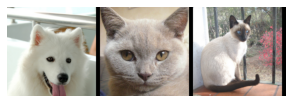

In [ ]:
it = ImageNTuple.create((files[0], files[1], files[2]))
it = Resize(224)(it)
it = ToTensor()(it)
it.show();

In [ ]:
test_eq(len(it), 3)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
